In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
import numpy as np

import warnings

from datetime import datetime
from datetime import timedelta
import calendar

from math import sin, cos, sqrt, atan2, radians

from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import folium

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

In [2]:
train = pd.read_csv("../input/New York City Taxi Trip Duration/train.csv")
test = pd.read_csv("../input/New York City Taxi Trip Duration/test.csv")
test.shape

(625134, 9)

### Convert to appropriate datatype

픽업 날짜 시간 및 반납 날짜 시간을 날짜 시간 개체로 변환합니다.

In [3]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Are there any missing values in the data?

In [4]:
train[pd.isnull(train)].sum()

id                    0  
vendor_id             0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0  
trip_duration         0.0
dtype: object

In [5]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

누락된 값이 없습니다.

### What is the time period of the dataset?

In [6]:
print(f'Min pickup time : {min(train["pickup_datetime"])}')
print(f'Max pickup time : {max(train["pickup_datetime"])}')

Min pickup time : 2016-01-01 00:00:17
Max pickup time : 2016-06-30 23:59:39


이 데이터에는 2016년 1월부터 6월까지 6개월간의 택시 여행 데이터가 포함되어 있습니다.

### create new day,month, hour info from Pickup time

In [7]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x: x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x: x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x: x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x: calendar.day_name[x.weekday()])

### Round lat lng to 3 decimal places

In [8]:
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x: round(x, 3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x: round(x, 3))
train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x: round(x, 3))
train['dropoff_longitude_round3'] = train['dropoff_longitude'].apply(lambda x: round(x, 3))

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


### Based on Latitude and Longitude get the distance of the trip in km

[Haversine 거리](https://kayuse88.github.io/haversine/)를 사용합니다.

In [9]:
def calculateDistance(row):
    R=6373.0 # approximate radius of earth in km
    pickup_lat=radians(row['pickup_latitude'])
    pickup_lon=radians(row['pickup_longitude'])
    dropoff_lat=radians(row['dropoff_latitude'])
    dropoff_lon=radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [10]:
train['trip_distance'] = train.apply(lambda row: calculateDistance(row), axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [11]:
train['trip_duration_in_hour']=train['trip_duration'].apply(lambda x:x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


### Exploratory Analysis

Text(0.5, 0, 'Trip Duration(in hour)')

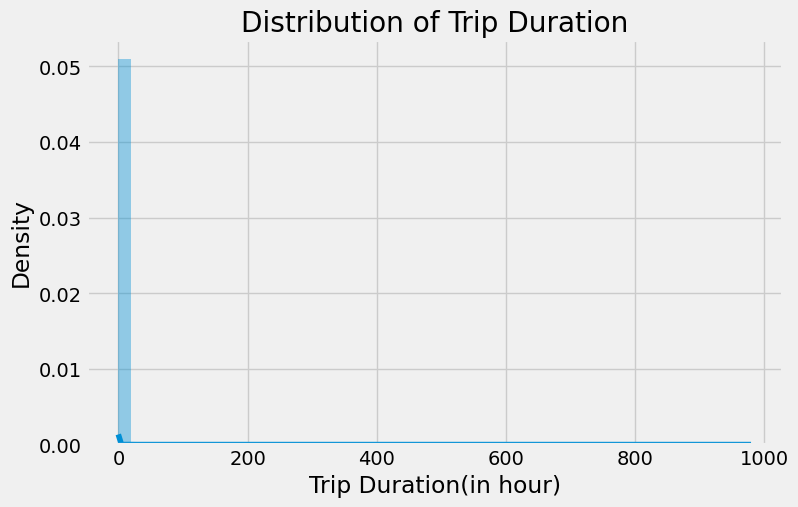

In [12]:
plt.figure(figsize=(8, 5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration(in hour)")

여행 기간이 24시간을 초과합니다. 이에 대해 조사해야 하나요?

In [13]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


여행 기간이 24시간을 초과하는 경우. 이에 대한 조사가 필요합니다.

In [14]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


여행 기간은 매우 길지만 이동 거리는 매우 짧은 기록이 4개 있습니다. 이는 이상치입니다. 하지만 이러한 여행이 시작되거나 끝나는 특정 위치가 있을까요? 여행 기간도 왜곡되어 있으므로 로그 변환을 해보겠습니다.

이러한 데이터도 테스트 데이터의 일부일 수 있으므로 분석에서 제거하지 않습니다.

Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

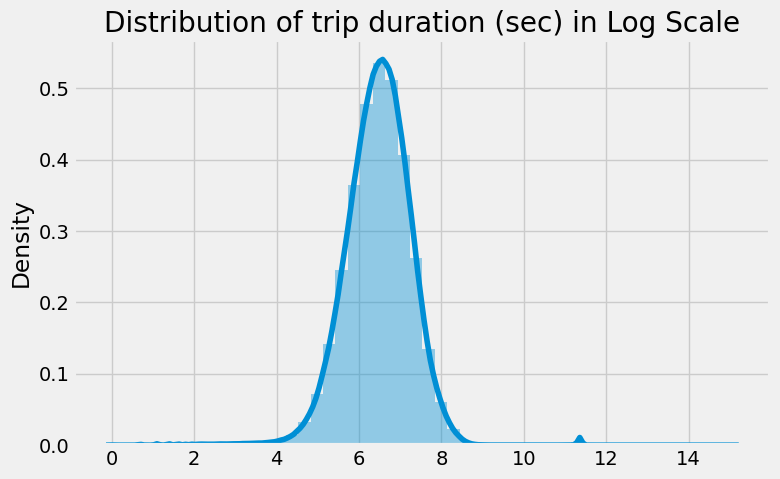

In [15]:
plt.figure(figsize=(8, 5))
sns.distplot(np.log(train['trip_duration'].values)).set_title("Distribution of Trip Duration")
plt.title("Distribution of trip duration (sec) in Log Scale")

여행 기간을 로그로 변환하면 정규 분포가 됩니다. 대부분의 트립은 54초(exp(4))에서 2980초(exp(8)) 사이입니다. 이는 대부분의 트립이 1시간 이내임을 나타냅니다. 그러나 1분 미만인 트립도 있어 자세히 살펴볼 필요가 있습니다. 100시간 동안 지속되는 여행이 있는데, 뉴욕 내에서 택시를 타는 것이기 때문에 이상합니다.

### Heatmap of common locations from where pickup and dropoff occurs

In [16]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id': 'Num_Trips'})

In [17]:
pickup_map = folium.Map(location= [40.730610, -73.935242], zoom_start=10,)

print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in pickup.iterrows(): 
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        fill_color="#3db7e4", 
                        fill_opacity=0.9
                       ).add_to(pickup_map)
    #count=count + 1
'''
hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Num_Trips.values.astype(float))),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
pickup_map.add_child(hm_wide)
pickup_map

(13024, 3)


(-74.03, -73.75)

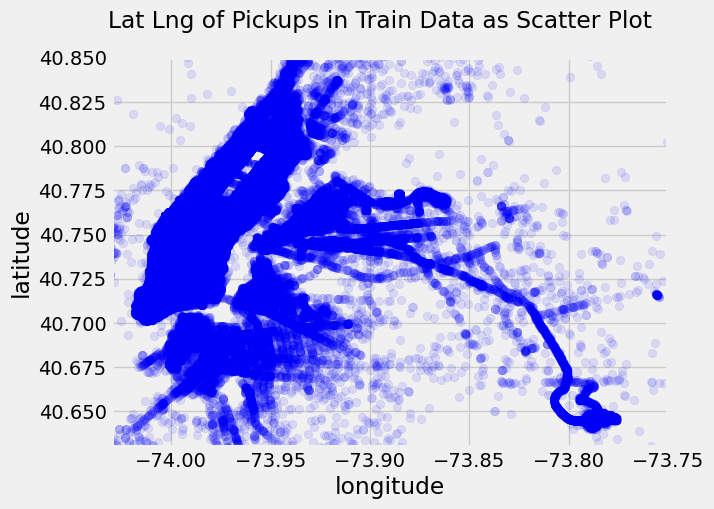

In [18]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              color='blue', label='train', alpha=0.1)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [19]:
drop = train.groupby(['dropoff_latitude_round3', 'dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id': 'Num_Trips'})

**이 그래프는 JFK 근처의 픽업 밀집도를 명확히 보여줍니다.**

In [20]:
drop_map = folium.Map(location= [40.730610, -73.935242], zoom_start=10,)

# print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in pickup.iterrows(): 
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        fill_color="#3db7e4", 
                        fill_opacity=0.9
                       ).add_to(pickup_map)
    #count=count + 1
'''
hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, pickup.Num_Trips.values.astype(float))),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
drop_map.add_child(hm_wide)
drop_map

하차 히트맵은 승차와 유사합니다.

### heatmap of trip duration, when pickup originates from a point

In [21]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration': 'Avg_Trip_duration'})

In [22]:
pickup_map = folium.Map(location= [40.730610, -73.935242], zoom_start=10,)

hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values,pickup.pickup_longitude_round3.values, pickup.Avg_Trip_duration.values.astype(float))),
                     min_opacity=0.2,
                     radius=7, blur=15,
                     max_zoom=1 
                 )
pickup_map.add_child(hm_wide)
pickup_map

JFK에서 출발할 때 평균 여행 기간이 더 길어집니다. 확대하면 맨해튼을 지나면 JFK에서 출발하는 픽업의 여행 시간이 더 길어지는 경향이 있음을 알 수 있습니다.

### Which hours are pickup and dropoff higher?

Text(0.5, 1.0, 'Pickup Hours Distribution')

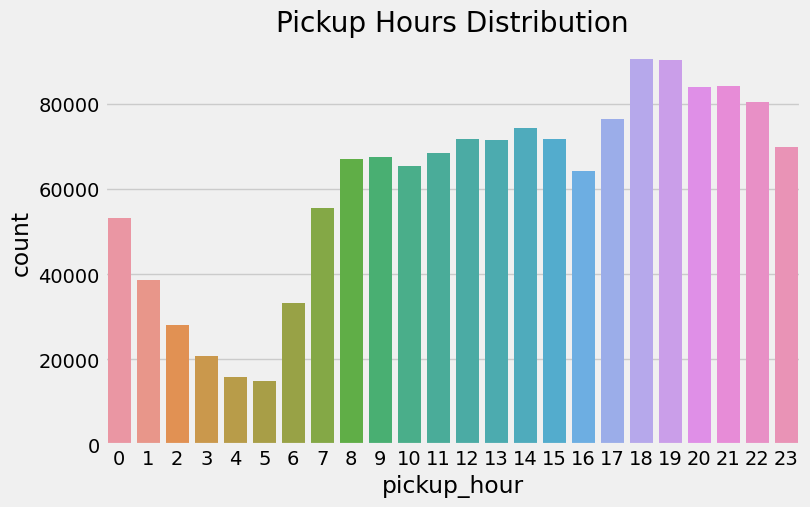

In [23]:
plt.figure(figsize=(8, 5))
sns.countplot(x=train['pickup_hour']).set_title('Pickup Hours Distribution')

이른 아침에는 픽업수가 낮습니다. 대부분의 픽업은 오후 6시에서 8시 사이에 가장 높습니다.

Text(0.5, 1.0, 'Dropoff Hours Distribution')

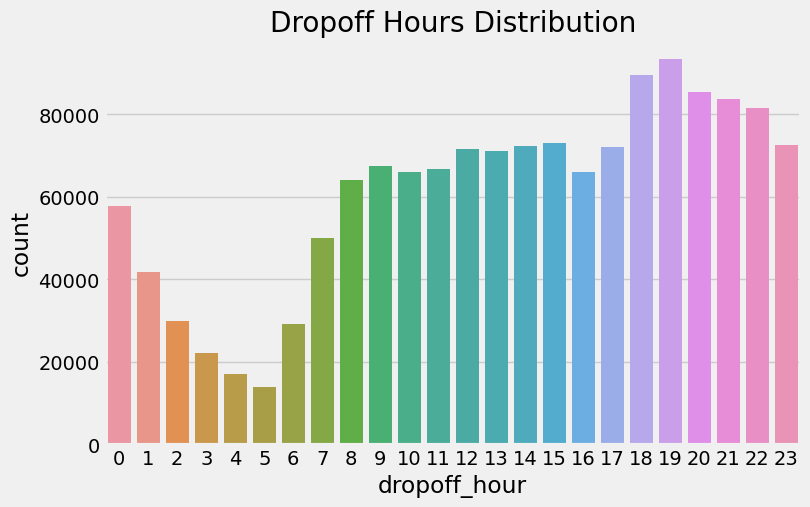

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(x=train['dropoff_hour']).set_title("Dropoff Hours Distribution")

하차시간 분포는 픽업 시간과 매우 유사합니다.

### Pickups over the entire time period

Text(0.5, 1.0, 'Distribution of Pickup over time')

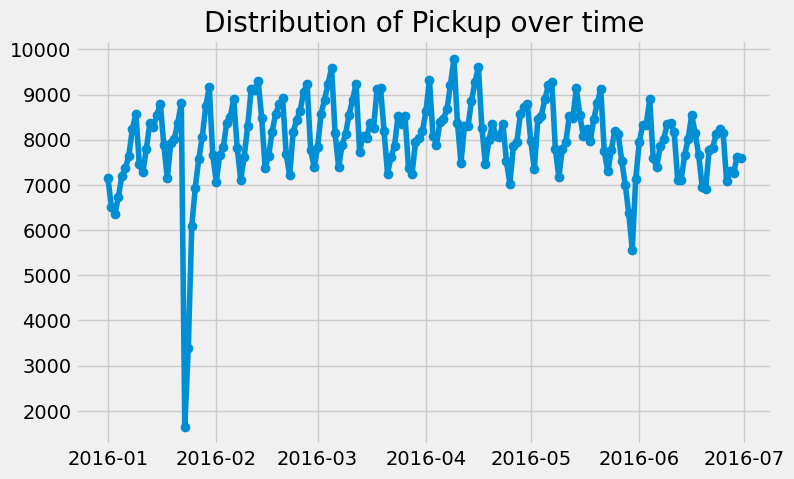

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')

plt.title("Distribution of Pickup over time")

2016년 1월 말 픽업 건수가 감소했습니다.

### What is the distribution of Trip distance

Text(0.5, 0, 'Trip Distance (Log)')

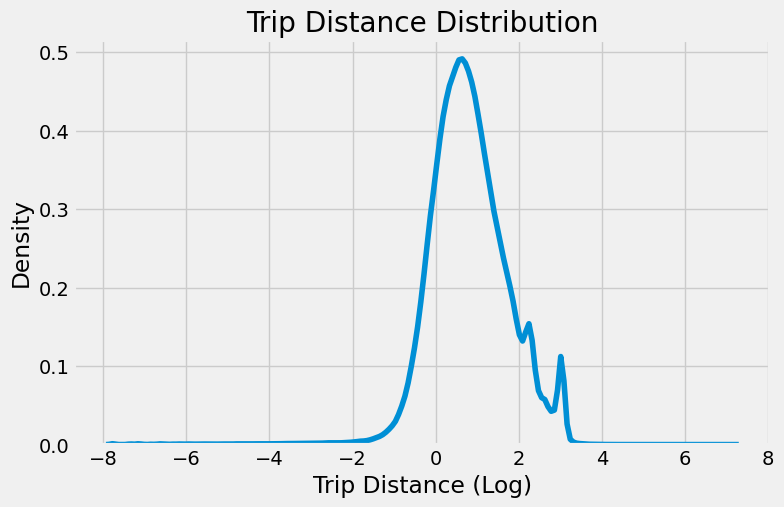

In [26]:
plt.figure(figsize=(8, 5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance (Log)")

### Trip Duration vs Trip Distance

Text(0, 0.5, 'Trip Duration (log scale)')

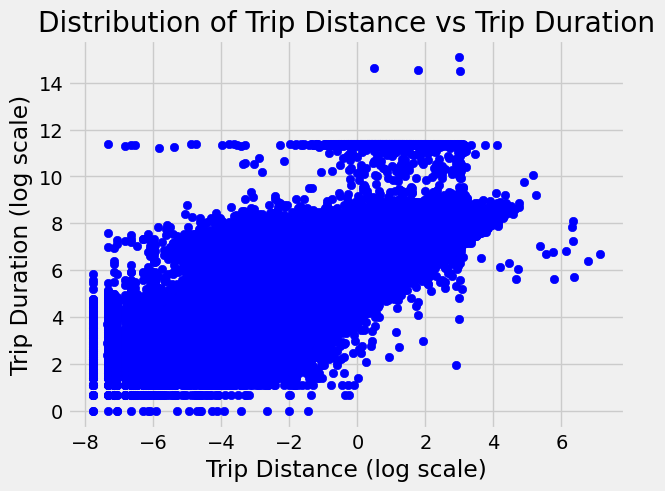

In [27]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
           color='blue', label='train')
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")

### Is the trip duration higher at different hours?

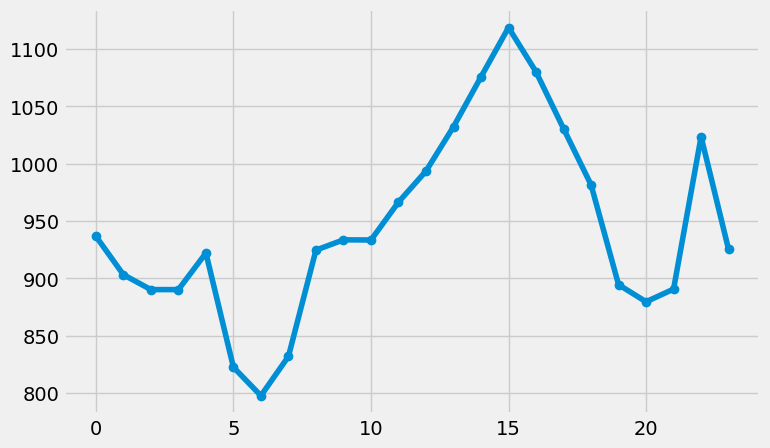

In [28]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration': 'avg_trip_duration'})
plt.figure(figsize=(8, 5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(), 'o-')

여행 시간은 10시간에서 15시간 사이로 늘어납니다.

### Distribution of Pickups across Days

<Axes: xlabel='pickup_day_of_week', ylabel='count'>

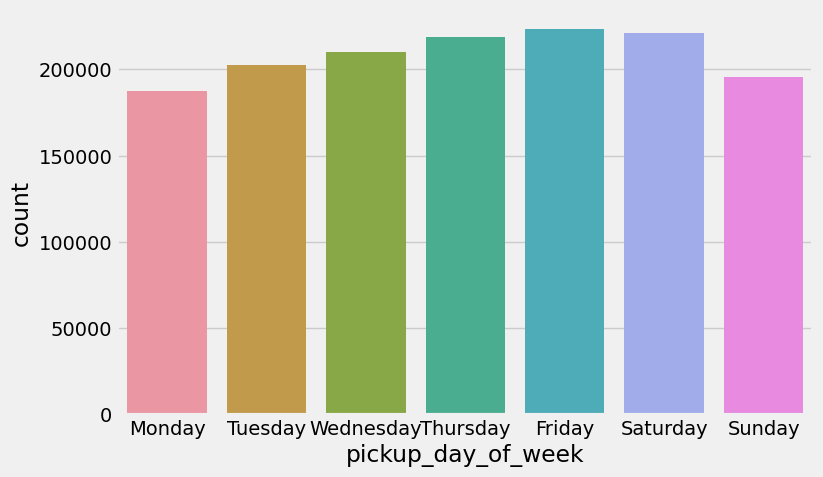

In [29]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_day_of_week'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])

월요일에는 픽업 횟수가 매우 적고 화요일부터 금요일까지 픽업 횟수가 계속 증가합니다.

### Avg Trip Duration over Days of week

In [30]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration': 'avg_trip_duration'})

Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

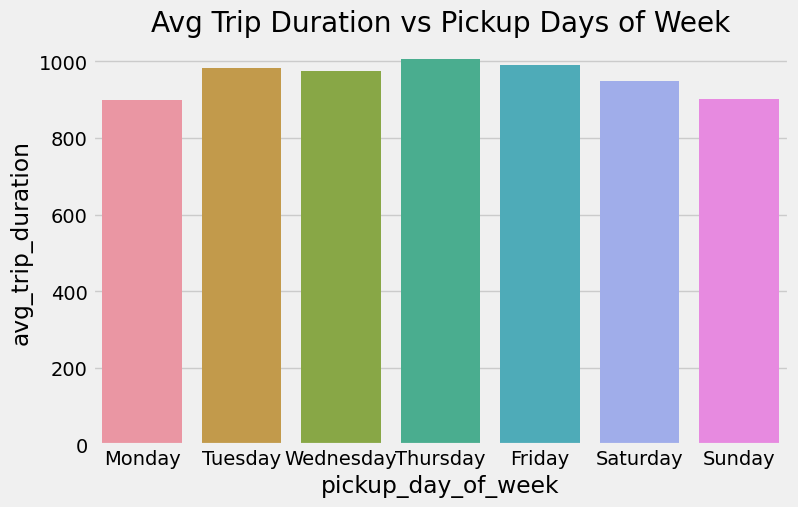

In [31]:
plt.figure(figsize=(8, 5))
sns.barplot(x='pickup_day_of_week', y='avg_trip_duration', data=avg_duration_day, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Trip Duration vs Pickup Days of Week")

평균 탑승 시간이 가장 높은 날은 목요일입니다.

### Create a caluclated field Bearing

베어링은 이동 방향을 측정합니다. 공식은 다음과 같습니다. 
$$ θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ ) λ $$
λ는 경도입니다.

In [32]:
def calculateBearing(lat1, lng1, lat2, lng2):
    R = 6371
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [33]:
train['bearing'] = train.apply(lambda row: calculateBearing(row['pickup_latitude_round3'], row['pickup_longitude_round3'], row['dropoff_latitude_round3'], row['dropoff_longitude_round3']), axis=1)

### Distribution of Bearing

<Axes: xlabel='bearing', ylabel='Density'>

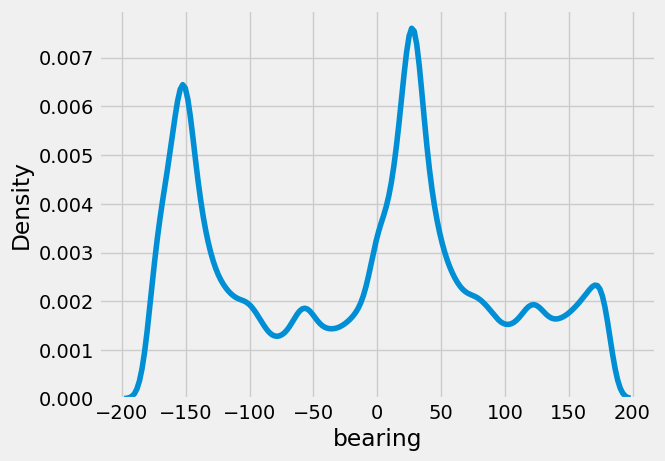

In [34]:
sns.kdeplot(train['bearing'])

### Bearing vs Trip Duration

Text(0, 0.5, 'Trip Duration (log scale)')

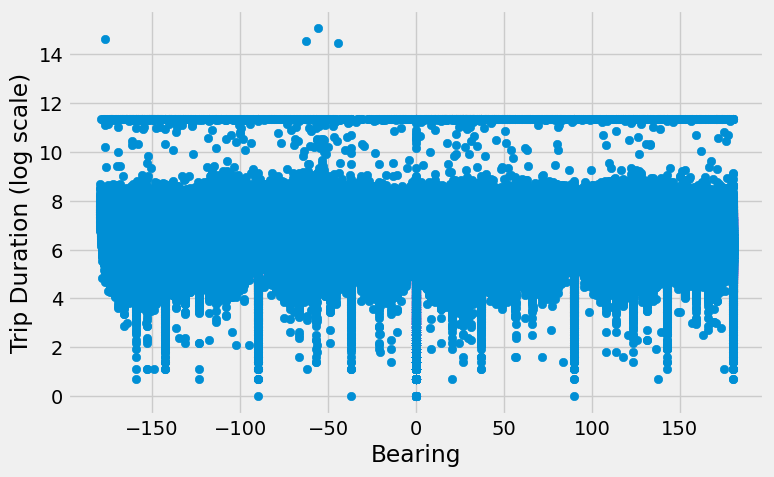

In [35]:
plt.figure(figsize=(8, 5))
plt.scatter(train['bearing'].values, y=np.log(train['trip_duration'].values))
plt.xlabel("Bearing")
plt.ylabel("Trip Duration (log scale)")

여행 기간의 이상값은 모두 방위 -50도 부근에 있습니다.

### Distribution of Store and FWD Flag

In [36]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

Text(0, 0.5, 'Density')

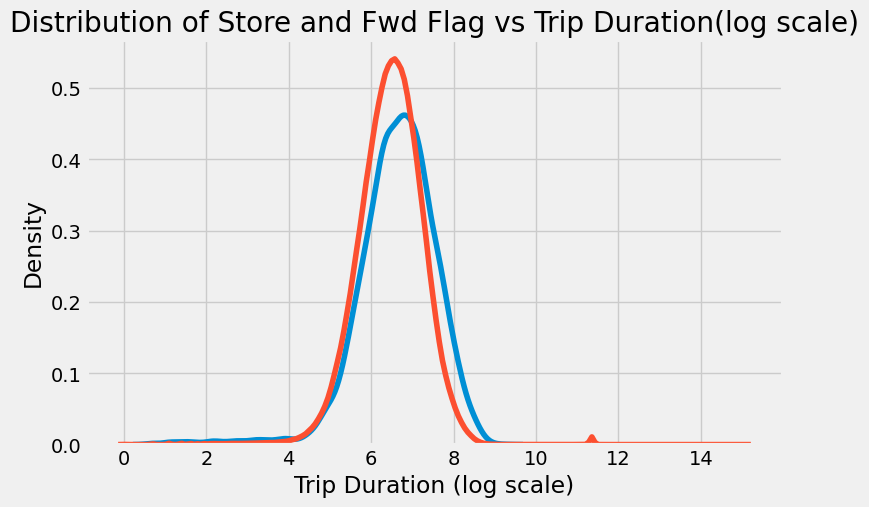

In [37]:
plt.figure(figsize=(8, 5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'Y', 'trip_duration'].values), label='Store and Fwd =Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'N', 'trip_duration'].values), label='Store and Fwd =No')

plt.title("Distribution of Store and Fwd Flag vs Trip Duration(log scale)")
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')

### Group Locations into cluster

이렇게 하면 이웃을 만드는 데 도움이 됩니다. 특정 지역에서의 픽업은 이동 시간이 더 길어질 수 있습니다.

(-74.03, -73.75)

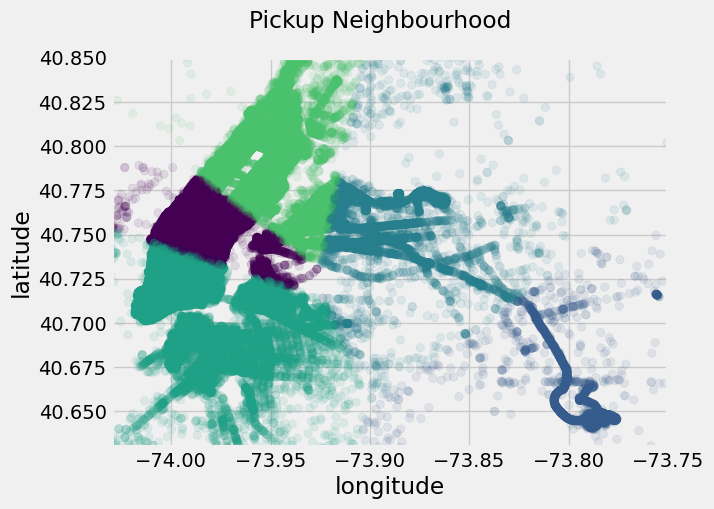

In [38]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
    
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
          c=train['pickup_neighbourhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

### Number of pickups in each neighbourhood

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourhoods')

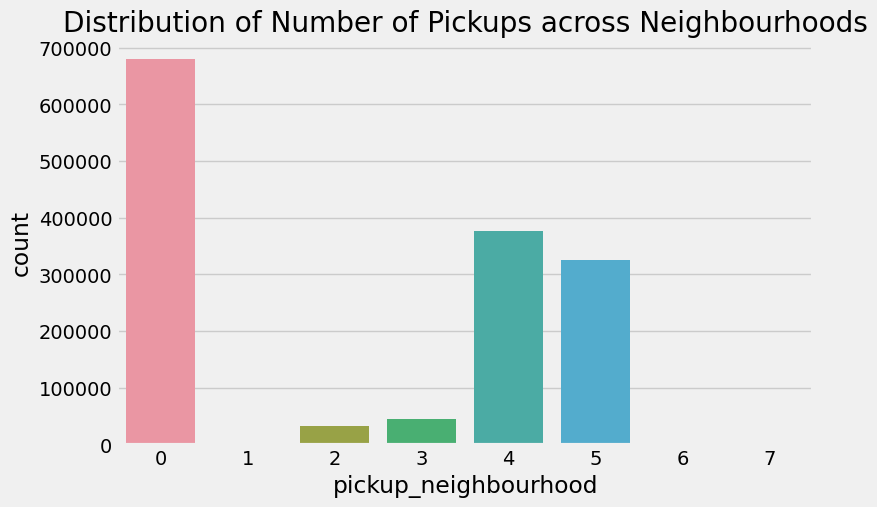

In [39]:
plt.figure(figsize=(8, 5))
sns.countplot(x=train['pickup_neighbourhood']).set_title("Distribution of Number of Pickups across Neighbourhoods")

Text(0.5, 1.0, 'Avg Trip Duration vs Neighbourhood')

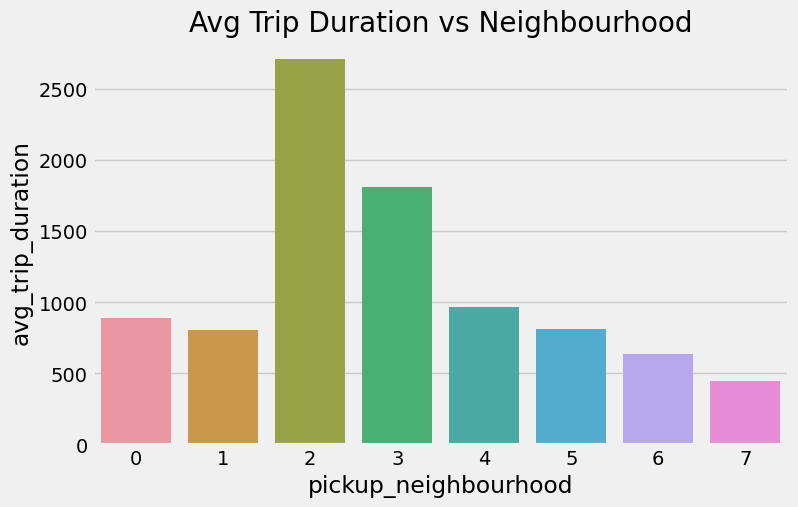

In [40]:
avg_duration_neighbourhood = train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration': 'avg_trip_duration'})
plt.figure(figsize=(8, 5))
sns.barplot(x='pickup_neighbourhood', y='avg_trip_duration', data=avg_duration_neighbourhood).set_title("Avg Trip Duration vs Neighbourhood")

이웃 2는 평균 여행 시간이 매우 길지만, 이웃 0은 픽업이 가장 많습니다.

### Distribution of Average speed

Text(0.5, 1.0, 'Distribution of Average Speed (in kph)')

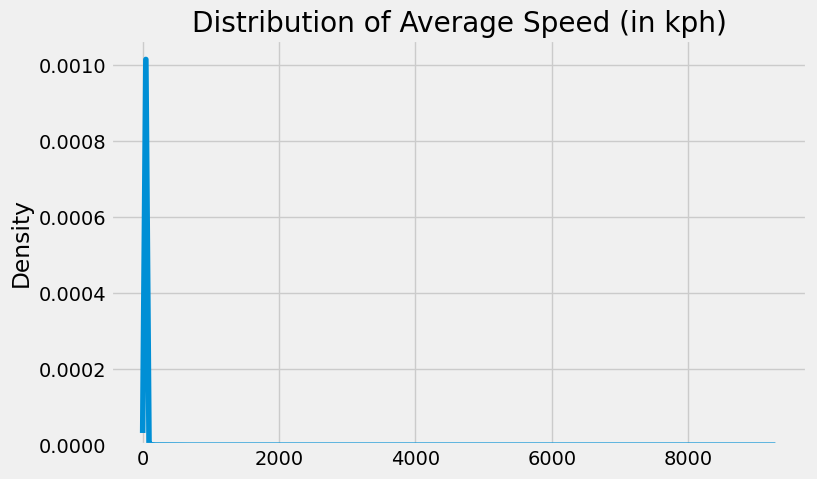

In [41]:
train['avg_speed_kph'] = train['trip_distance'] / train['trip_duration_in_hour']
plt.figure(figsize=(8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title("Distribution of Average Speed (in kph)")

In [42]:
print(f"Average speed is {np.mean(train['avg_speed_kph'])} kph")

Average speed is 14.427736738459107 kph


### Average Speed across days of week - this is indication of traffic speed.

Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

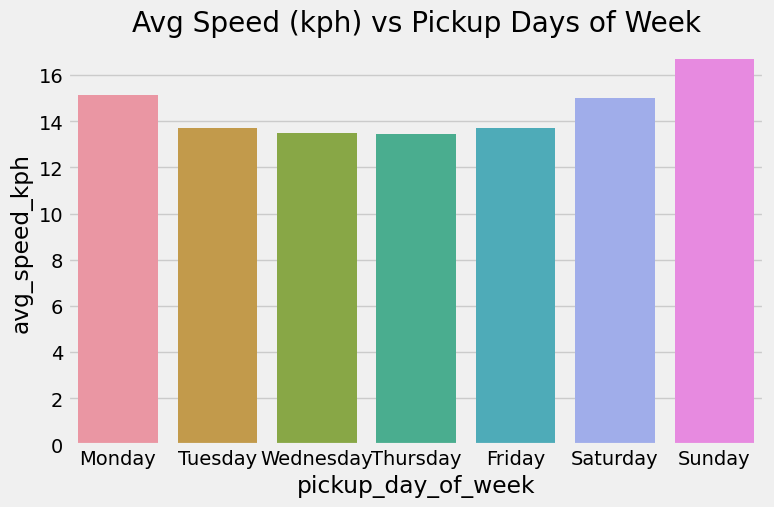

In [44]:
avg_speed_per_day = train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='pickup_day_of_week', y='avg_speed_kph', data=avg_speed_per_day, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).set_title("Avg Speed (kph) vs Pickup Days of Week")

일요일과 월요일에 평균 속도가 더 빠릅니다.

### Feature Engineering on Test Data

In [46]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
#test['dropoff_datetime']=pd.to_datetime(test['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
#test['dropoff_date']= test['dropoff_datetime'].dt.date
#test['dropoff_day']=test['dropoff_datetime'].apply(lambda x:x.day)
#test['dropoff_hour']=test['dropoff_datetime'].apply(lambda x:x.hour)
#test['dropoff_day_of_week']=test['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:calculateDistance(row),axis=1)
#test['trip_duration_in_hour']=test['trip_duration'].apply(lambda x:x/3600)
test['bearing']=test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

### Building Models

학습 데이터에서 "드롭오프 날짜/시간 기능"을 삭제해야 합니다. 또한 위도 경도도 소수점 셋째 자리까지만 반올림합니다.

In [48]:
drop_cols=['avg_speed_kph','trip_duration_in_hour','dropoff_date','dropoff_day','dropoff_hour','dropoff_day_of_week','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
training = train.drop(drop_cols, axis=1)
testing = test.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)

trip_duration을 예측해야 합니다. 이를 로그 스케일로 변환하고 다음을 예측합니다.

In [49]:
training['log_trip_duration'] = training['trip_duration'].apply(lambda x: np.log(x))
training.drop(['trip_duration'], axis=1, inplace=True)

In [50]:
print(f'Training Data Shape {training.shape}')
print(f'Testing Data Shape {testing.shape}')

Training Data Shape (1458644, 18)
Testing Data Shape (625134, 17)


요일도 숫자로 인코딩해 보겠습니다.

In [51]:
def encodeDays(day_of_week):
    day_dict = {'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]

In [53]:
training['pickup_day_of_week'] = training['pickup_day_of_week'].apply(lambda x: encodeDays(x))
testing['pickup_day_of_week'] = testing['pickup_day_of_week'].apply(lambda x: encodeDays(x))

In [55]:
training.to_csv("input_training.csv", index=False)
testing.to_csv("input_testing.csv", index=False)
del training
del testing
del train
del test

In [58]:
def LabelEncoding(train_df, test_df, max_levels=2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col] = le.transform(train_df[col])
                test_df[col] = le.transform(test_df[col])
    return [train_df, test_df]

def readInputAndEncode(input_path, train_file, test_file, target_column):
    training = pd.read_csv(input_path + train_file)
    testing = pd.read_csv(input_path + test_file)
    
    training, testing = LabelEncoding(training, testing)
    
    # print("Training Data Shape after Encoding ",training.shape)
    # print("Testing Data Shape after Encoding ",testing.shape)
    # Check if all train columns are there in test data. If not add the column to test data and replace it with zero
    
    train_cols = training.columns.tolist()
    test_cols = testing.columns.tolist()
    col_in_train_not_test = set(train_cols) - set(test_cols)
    for col in col_in_train_not_test:
        if col != target_column:
            testing[col] = 0
    col_in_test_not_train = set(test_cols) - set(train_cols)
    for col in col_in_test_not_train:
        training[col] = 0
    print("Training Data Shape after Processing ",training.shape)
    print("Testing Data Shape after Processing ",testing.shape)
    return [training,testing]

In [59]:
train, test = readInputAndEncode("", 'input_training.csv', 'input_testing.csv', 'log_trip_duration')
train.drop(['pickup_date'], axis=1, inplace=True)
test.drop(['pickup_date'], axis=1, inplace=True)
train.drop(['pickup_datetime'], axis=1, inplace=True)
test.drop(['pickup_datetime'], axis=1, inplace=True)
test_id = test['id']
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

Training Data Shape after Processing  (1458644, 18)
Testing Data Shape after Processing  (625134, 17)


In [64]:
def GetFeaturesAndSplit(train, test, target, imputing_strategy='median', split=0.25, imputation=True):
    labels = np.array(train[target])
    training = train.drop(target, axis=1)
    training = np.array(training)
    testing = np.array(test)
    if imputation == True:
        imputer = SimpleImputer(strategy=imputing_strategy, missing_values=np.nan)
        imputer.fit(training)
        training = imputer.transform(training)
        testing = imputer.transform(testing)
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size=split, random_state=42)
    return [train_features, validation_features, train_labels, validation_labels, testing]

In [66]:
train_features, validation_features, train_labels, validation_labels, testing = GetFeaturesAndSplit(train, test, 'log_trip_duration', imputation=False)

### Apply Linear Regression

In [67]:
lm = linear_model.LinearRegression()
lm.fit(train_features, train_labels)

LinearRegression()

In [68]:
valid_pred = lm.predict(validation_features)

In [69]:
rmse = mean_squared_error(validation_labels, valid_pred)
print(f'Root Mean Squared Error for Linear Regression(log scale) {rmse}')

Root Mean Squared Error for Linear Regression(log scale) 0.4031176249688147


In [70]:
test_pred = lm.predict(testing)
submit = pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv("submission_linear_regression_baseline.csv", index=False)
del submit

### Apply Random Forest Regressor

In [71]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [72]:
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

In [73]:
valid_pred_rf = rf.predict(validation_features)
rmse = mean_squared_error(validation_labels, valid_pred_rf)
print(f'Root Mean Squared Error for Random Forest {rmse}')

Root Mean Squared Error for Random Forest 0.1658568303881011


In [74]:
test_pred = rf.predict(testing)
submit = pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv("submission_random_forest_baseline.csv", index=False)